In [ ]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

In [5]:
from os.path import expanduser
import sys
motornet_home = expanduser("~") + "/MotorNet"
sys.path.append(motornet_home)

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import motornet as mn
from motornet.plants.muscles import RigidTendonHillMuscleThelen
import plg_tasks

# Disable all GPUS
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# SET UP PLANT
plant = mn.plants.RigidTendonArm26(muscle_type=RigidTendonHillMuscleThelen(), visual_delay=0.07, proprioceptive_delay=0.02)

# SET UP NETWORK
n_units = 256
network = mn.nets.layers.GRUNetwork(plant=plant, n_units=n_units, kernel_regularizer=1e-7, name='network', recurrent_regularizer=1e-5)

# SET UP TASK
start_joint_position = [0.785, 1.570] # [45,90] deg
go_cue_range = [.100, .400]
task = plg_tasks.CentreOutReachFF(network=network, start_joint_position=start_joint_position, go_cue_range=go_cue_range)
task.network.do_recompute_inputs = True
task.network.recompute_inputs = task.recompute_inputs
#task.loss_weights['cartesian position'] = 1.0
#task.loss_weights['muscle state'] = 5.0

rnn = tf.keras.layers.RNN(cell=network, return_sequences=True, name='RNN')

input_dict = task.get_input_dict_layers()
state0 = task.get_initial_state_layers()
states_out = rnn(input_dict, initial_state=state0)

nn = mn.nets.MotorNetModel(inputs=[input_dict, state0], outputs=states_out, name='model', task=task)
nn.compile(optimizer=tf.optimizers.Adam(clipnorm=1.), loss=task.losses, loss_weights=task.loss_weights)

In [8]:
task.get_losses()


[{'joint position': None,
  'cartesian position': <motornet.nets.losses.PositionLoss at 0x7fac302ec550>,
  'muscle state': <motornet.nets.losses.L2xDxActivationLoss at 0x7fac302ec940>,
  'geometry state': None,
  'proprioceptive feedback': None,
  'visual feedback': None,
  'excitation': None,
  'gru_hidden0': <motornet.nets.losses.L2xDxRegularizer at 0x7fac302ec9a0>},
 {'joint position': 0.0,
  'cartesian position': 1.0,
  'muscle state': 5,
  'geometry state': 0.0,
  'proprioceptive feedback': 0.0,
  'visual feedback': 0.0,
  'excitation': 0.0,
  'gru_hidden0': 0.1}]

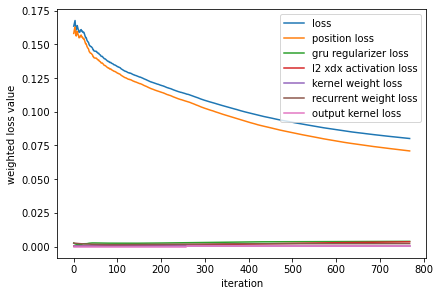

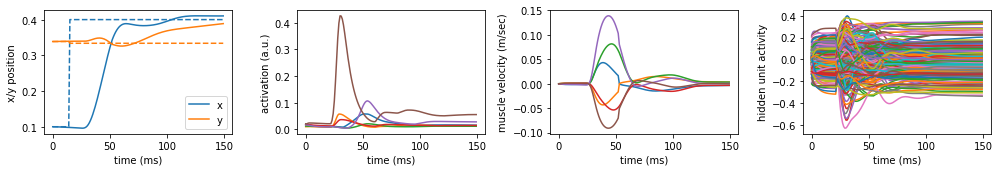

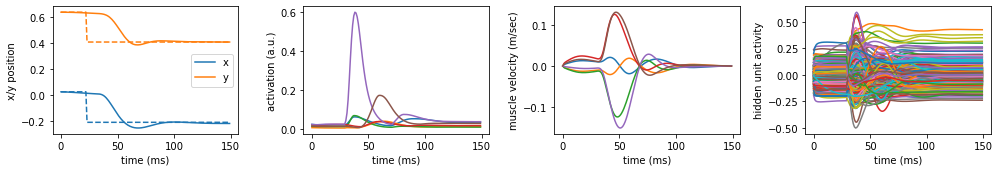

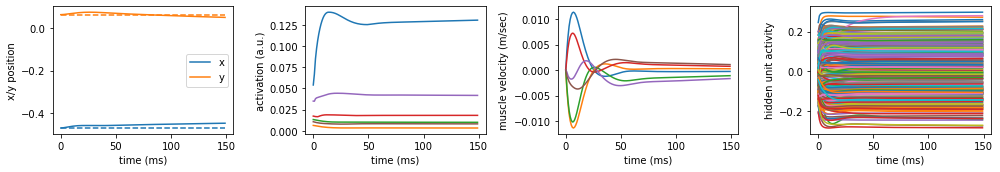

 935/1024 [==========================>...] - ETA: 42s - loss: 0.0755 - position_loss: 0.0658 - gru_regularizer_loss: 0.0379 - l2_xdx_activation_loss: 7.8817e-04

KeyboardInterrupt: 

In [9]:
# TRAIN THE NETWORK
n_t = 150
n_batches = 1024
batch_size = 64
# this callback logs training information for each batch passed, rather than for each epoch.
callbacks = [mn.nets.callbacks.BatchLogger(), mn.nets.callbacks.TrainingPlotter(task,plot_freq=256,plot_trials=3,plot_n_t=n_t)]
for i in range(5):
    [inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=n_batches * batch_size)
    h = nn.fit(x=[inputs, init_states], y=targets, verbose=1, epochs=1, batch_size=batch_size, shuffle=False, callbacks=callbacks)

In [7]:
# TEST THE NETWORK ON THE CENTRE-OUT REACHING TASK
task.angle_step = 45
[inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=1, validation=True)
results = nn([inputs, init_states], training=False)

In [ ]:
def hand_to_joints(xy, L1, L2):
      j = np.zeros(np.shape(xy))
      j[:,:,1] = np.arccos((xy[:,:,0]**2 + xy[:,:,1]**2 - L1**2 - L2**2) / (2*L1*L2))
      j[:,:,0] = np.arctan2(xy[:,:,1],xy[:,:,0]) - np.arctan2(L2*np.sin(j[:,:,1]),L1+(L2*np.cos(j[:,:,1])))
      return j

def plot_simulations(xy, target_xy):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]

  plt.figure()
  plotor(xy)
  plt.scatter(target_x, target_y)
  plt.xlabel("X (m)")
  plt.ylabel("Y (m)")
  plt.show()

def plot1trial(inputs, results, targets_j, trial=0):
    j_results = results['joint position']
    m_results = results['muscle state']

    plt.figure(figsize=(14, 2.5)).set_tight_layout(True)

    plt.subplot(141)
    plt.plot(j_results[trial, :, 0]*180/np.pi, label='sho')
    plt.plot(j_results[trial, :, 1]*180/np.pi, label='elb')
    plt.plot(targets_j[trial, :, 0]*180/np.pi, '--')
    plt.plot(targets_j[trial, :, 1]*180/np.pi, '--')
    plt.axvline(np.where(inputs["inputs"][trial, :, -1] != 1)[0][0] - network.visual_delay, c='grey')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle (deg)')

    plt.subplot(142)
    plt.plot(j_results[trial, :, 2], label='sho')
    plt.plot(j_results[trial, :, 3], label='elb')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle velocity (rad/sec)')

    plt.subplot(143)
    plt.plot(m_results[trial, :, 0, :])
    plt.xlabel('time (ms)')
    plt.ylabel('activation (a.u.)')
    plt.legend(["PEC","DEL","BRA","TRI","BIC","TR2"], loc=1)

    plt.subplot(144)
    plt.plot(m_results[trial, :, -1, :])
    plt.xlabel('time (ms)')
    plt.ylabel('force (N)')
    plt.legend(["PEC","DEL","BRA","TRI","BIC","TR2"], loc=1)

    plt.show()

plotor = mn.utils.plotor.plot_pos_over_time


In [ ]:
# TEST THE NETWORK ON THE CENTRE-OUT REACHING TASK

n_t = 150
nn.task.angle_step = 45
[inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=8, centre_out_test=True)
results = nn([inputs, init_states], training=False)

plot_simulations(xy=results["cartesian position"], target_xy=targets)

L1,L2 = nn.task.network.plant.skeleton.L1, nn.task.network.plant.skeleton.L2
targets_j = hand_to_joints(targets, L1, L2)
n_mov = np.shape(results["joint position"])[0]
for i in range(n_mov):
    plot1trial(inputs, results, targets_j, i)